# NSGA-II

NSGA-II is a fast, elitist multiobjective evolutionary algorithm designed to efficiently approximate the Pareto-optimal front. It overcomes several issues found in earlier nondominated sorting approaches by reducing computational complexity, ensuring elitism, and eliminating the need for a sharing parameter.

## Key Features

- **Fast Nondominated Sorting:**
  NSGA-II sorts the population based on Pareto dominance with a computational complexity of
  $O(MN^2)$, where $M$ is the number of objectives and $N$ is the population size.

- **Elitist Selection:**
  The algorithm creates a combined pool of parent and offspring populations. From this pool, the best solutions are chosen based on fitness and diversity. This elitist strategy ensures that the best-found solutions are preserved over generations.

- **Crowding Distance for Diversity Maintenance:**
  To maintain a diverse Pareto front, NSGA-II computes a *crowding distance* for each individual. For each front, the crowding distance $d_i$ of an individual $i$ is calculated as:

  $$
  d_i = \sum_{m=1}^{M} \frac{f_{m}^{(i+1)} - f_{m}^{(i-1)}}{f_{m}^{\max} - f_{m}^{\min}},
  $$

  where:

  - $f_{m}^{(i)}$ is the value of the $m$-th objective for the $i$-th individual (after sorting the individuals according to that objective),
  - $f_{m}^{\max}$ and $f_{m}^{\min}$ are the maximum and minimum values of the $m$-th objective in that front, respectively.


<div style="text-align: center;">
  <img src="../../images/nsga2_crowding.png" alt="Crowding distance" width="600px" />
</div>


  Individuals with a **larger crowding distance** are in less crowded regions and are preferred when selecting among solutions with the same non-domination rank, thereby promoting diversity across the Pareto front.

- **Constraint Handling:**
  When constraints_fn are present, NSGA-II modifies the selection process:
  - **Feasible Solutions First:** Feasible individuals (those satisfying all constraints_fn) are always preferred over infeasible ones.
  - **Ranking:** Among feasible solutions, those with a better (i.e., lower) nondominated rank are favored.
  - **Crowding Distance:** Finally, if individuals share the same rank, the one with a **larger crowding distance** is selected. This ensures that, within the same rank, solutions from less crowded regions of the objective space are chosen.

## ZDT3 Problem

**ZDT3** is a widely used benchmark in multiobjective optimization, especially for testing evolutionary algorithms. It challenges algorithms with:

- **Two Conflicting Objectives:**
  - $f_1(\mathbf{x}) = x_1$
  - $f_2(\mathbf{x}) = g(\mathbf{x}) \cdot h(f_1(\mathbf{x}), g(\mathbf{x}))$

- **Auxiliary Functions:**
  - $g(\mathbf{x}) = 1 + \frac{9}{n-1}\sum_{i=2}^{n} x_i$
  - $h(f_1, g) = 1 - \sqrt{\frac{f_1}{g}} - \frac{f_1}{g}\sin(10\pi f_1)$

- **Key Characteristics:**
  - **Discontinuous Pareto Front:** The optimal solutions are spread over several disconnected segments.
  - **Nonconvexity:** The Pareto front is nonconvex, making convergence more challenging.
  - **Diversity Maintenance:** The discontinuities force algorithms to preserve a diverse set of solutions.

**Domain:**
Each decision variable $x_i$ typically belongs to the interval $[0, 1]$, and the problem is often considered with $n = 30$ variables.

ZDT3 is ideal for evaluating how well an algorithm can balance convergence toward the Pareto-optimal front while maintaining diversity in the presence of a complex, discontinuous solution landscape.



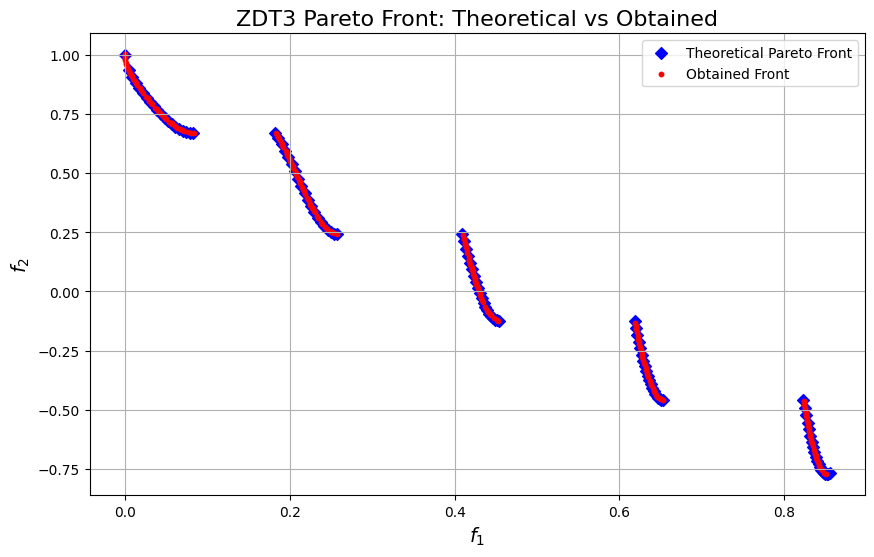

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from pymoors import (
    Nsga2,
    RandomSamplingFloat,
    GaussianMutation,
    ExponentialCrossover,
    CloseDuplicatesCleaner,
    Constraints
)
from pymoors.schemas import Population
from pymoors.typing import TwoDArray

np.seterr(invalid="ignore")


def evaluate_zdt3(population: TwoDArray) -> TwoDArray:
    """
    Evaluate the ZDT3 objectives in a fully vectorized manner.
    """
    # First objective: f1 is simply the first column.
    f1 = population[:, 0]
    n = population.shape[1]
    # Compute g for each candidate: g = 1 + (9/(n-1)) * sum(x[1:])
    g = 1 + (9 / (n - 1)) * np.sum(population[:, 1:], axis=1)
    # Compute h for each candidate: h = 1 - sqrt(f1/g) - (f1/g)*sin(10*pi*f1)
    h = 1 - np.sqrt(f1 / g) - (f1 / g) * np.sin(10 * np.pi * f1)
    # Compute the second objective: f2 = g * h
    f2 = g * h
    return np.column_stack((f1, f2))


def zdt3_theoretical_front():
    """
    Compute the theoretical Pareto front for ZDT3.

    Returns:
        f1_theo (np.ndarray): f1 values on the theoretical front.
        f2_theo (np.ndarray): Corresponding f2 values.

    Instead of using a dense linspace, we sample only a few points per interval to
    clearly illustrate the discontinuous nature of the front.
    """
    # Define the intervals for f1 where the Pareto front exists
    intervals = [
        (0.0, 0.0830015349),
        (0.1822287280, 0.2577623634),
        (0.4093136748, 0.4538828821),
        (0.6183967944, 0.6525117038),
        (0.8233317983, 0.85518),
    ]

    f1_theo = np.array([])
    f2_theo = np.array([])

    # Use a small number of points per interval (e.g., 20) to highlight the discontinuities.
    for start, end in intervals:
        f1_vals = np.linspace(start, end, 20)
        f2_vals = 1 - np.sqrt(f1_vals) - f1_vals * np.sin(10 * np.pi * f1_vals)
        f1_theo = np.concatenate((f1_theo, f1_vals))
        f2_theo = np.concatenate((f2_theo, f2_vals))

    return f1_theo, f2_theo


# Set up the NSGA2 algorithm with the above definitions
algorithm = Nsga2(
    sampler=RandomSamplingFloat(min=0, max=1),
    crossover=ExponentialCrossover(exponential_crossover_rate=0.75),
    mutation=GaussianMutation(gene_mutation_rate=0.1, sigma=0.01),
    fitness_fn=evaluate_zdt3,
    constraints_fn=Constraints(lower_bound=0.0, upper_bound=1.0),
    duplicates_cleaner=CloseDuplicatesCleaner(epsilon=1e-5),
    num_vars=30,
    population_size=200,
    num_offsprings=200,
    num_iterations=300,
    mutation_rate=0.1,
    crossover_rate=0.9,
    keep_infeasible=False,
    verbose=False,
)

# Run the algorithm
algorithm.run()

# Get the best Pareto front obtained (as a Population instance)
best: Population = algorithm.population.best_as_population

# Extract the obtained fitness values (each row is [f1, f2])
obtained_fitness = best.fitness
f1_found = obtained_fitness[:, 0]
f2_found = obtained_fitness[:, 1]

# Compute the theoretical Pareto front for ZDT3
f1_theo, f2_theo = zdt3_theoretical_front()

# Plot the theoretical Pareto front and the obtained front
plt.figure(figsize=(10, 6))
# Plot theoretical front as markers (e.g., diamonds) to show discontinuities.
plt.scatter(
    f1_theo, f2_theo, marker="D", color="blue", label="Theoretical Pareto Front"
)
# Plot obtained front as red circles.
plt.scatter(f1_found, f2_found, c="r", marker="o", s=10, label="Obtained Front")
plt.xlabel("$f_1$", fontsize=14)
plt.ylabel("$f_2$", fontsize=14)
plt.title("ZDT3 Pareto Front: Theoretical vs Obtained", fontsize=16)
plt.legend()
plt.grid(True)